### This tutorial demostrate how to build a residual block of residual network (ResNet) formulated as follows:

`He, Kaiming, et al. "Deep residual learning for image recognition." 2015`

## $$x^{(1)}=ReLU(W^{(1)} * x^{(0)})$$
## $$x^{(2)}=ReLU(W^{(2)} * x^{(1)} + x^{(0)})$$

In [1]:
# import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt
# set to plot in the notebook
%matplotlib inline 

# import keras (using tensorflow backend)
import keras

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.visible_device_list= '0'
set_session(tf.Session(config=config))

In [3]:
from keras.datasets import cifar10

# set batch size and number of classes
input_shape = (32,32,3)
batch_size = 500
num_classes = 10
epochs = 10

# load cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# convert class vectors to one-hot binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# normalize data to [-1, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 127.5
x_test /= 127.5
x_train -= 1.
x_test -= 1.

In [4]:
from keras.models import Sequential

from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Add

from keras.engine.topology import Layer


# define the residual block as a layer
class Residual(Layer):
    def __init__(self, channels_in,kernel,**kwargs):
        super(Residual, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel

    def call(self, x):
        # the residual block using Keras functional API
        first_layer =   Activation("linear", trainable=False)(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(first_layer)
        x =             Activation("relu")(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(x)
        residual =      Add()([x, first_layer])
        x =             Activation("relu")(residual)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

    
def res_model(input_shape, num_classes):    
    model = Sequential()

    # conv1
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=input_shape))
    model.add(Activation('relu'))
    # pool1
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))

    # conv2 (residual block)
    model.add(Residual(32,(3,3)))
    # pool2
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))

    # conv3
    model.add(Conv2D(120, (7, 7), padding='valid'))
    model.add(Activation('relu'))

    # conv4
    model.add(Conv2D(num_classes, (1, 1), padding='valid'))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    return model

model = res_model(input_shape, num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 15, 15, 32)        0         
_________________________________________________________________
residual_1 (Residual)        (None, 15, 15, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
activation_6 (Activation)    (None, 7, 7, 32)          0         
__________

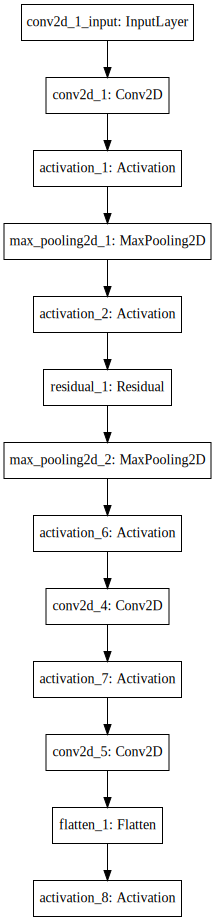

In [5]:
# you can save model diagram by following code
from keras.utils import plot_model
plot_model(model, to_file='res_model.png')

# show model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [6]:
# compile model
optimizer = keras.optimizers.sgd()
loss = keras.losses.categorical_crossentropy
metric = keras.metrics.categorical_accuracy
model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

# import image data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

# Compute quantities required for feature-wise normalization
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test))

Epoch 1/10
100/100 [==============================] - 2s 23ms/step - loss: 2.2188 - categorical_accuracy: 0.1894 - val_loss: 2.1292 - val_categorical_accuracy: 0.2623
Epoch 2/10
100/100 [==============================] - 1s 15ms/step - loss: 2.0537 - categorical_accuracy: 0.2886 - val_loss: 1.9826 - val_categorical_accuracy: 0.3155
Epoch 3/10
100/100 [==============================] - 1s 15ms/step - loss: 1.9327 - categorical_accuracy: 0.3298 - val_loss: 1.8835 - val_categorical_accuracy: 0.3474
Epoch 4/10
100/100 [==============================] - 2s 15ms/step - loss: 1.8494 - categorical_accuracy: 0.3571 - val_loss: 1.8124 - val_categorical_accuracy: 0.3674
Epoch 5/10
100/100 [==============================] - 1s 15ms/step - loss: 1.7871 - categorical_accuracy: 0.3764 - val_loss: 1.7596 - val_categorical_accuracy: 0.3867
Epoch 6/10
100/100 [==============================] - ETA: 0s - loss: 1.7378 - categorical_accuracy: 0.39 - 1s 15ms/step - loss: 1.7379 - categorical_accuracy: 0.395

In [7]:
[train_loss, train_acc] = history.model.evaluate(x=x_train, y=y_train, batch_size=batch_size, verbose=0)
print("Train accuracy:{0:.2f}%.".format(train_acc*100))

Train accuracy:45.96%.


In [8]:
[test_loss, test_acc] = history.model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=0)
print("Test accuracy:{0:.2f}%.".format(test_acc*100))

Test accuracy:45.78%.
